In [8]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from Dataset2 import ProcessingDatasetContainer



In [9]:
Dataset_Name = 'LSTM_Axis_Dataset'

Model_Names  = ['Model_Axis_LSTM_JustX',\
                'Model_Axis_LSTM_JustY',\
                'Model_Axis_LSTM_JustZ',\
                'Model_Axis_LSTM_JustSDPPhi',\
                'Model_Axis_LSTM_JustCEDist']


In [10]:
# Extra settings
Dataset_Batch_Size = 256 # Adjustable, in case

### Loading Data and Models, Processing Predictions


In [11]:
# Establish paths to the models
Models_Path  = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Models'
Dataset_Path = '/remote/tychodata/ftairli/work/Projects/LSTM_Reconstruction/Data'

In [12]:
# Importing Dataset Here
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt')
Dataset.AssignIndices()
Dataset.State = 'Test'

In [13]:
print(Dataset.Truth_Keys)
print(Dataset.Truth_Units)

['x', 'y', 'z', 'SDPPhi', 'CEDist']
['', '', '', 'deg', 'km']


In [14]:
# Compute the Test Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Dataset.State      = 'Test'
torch.cuda.empty_cache()
Dataset.BatchSize  = 64
Dataset.RandomIter = False


Rec_Set   = []
Pred_Set  = []
Truth_Set = []

# Check if the model names match the dataset 
# First figure out what models predict
for Model_Name in Model_Names:
    what_is_predicted = Model_Name.lower().split('just')[-1]
    lc_Truth_Keys = [key.lower() for key in Dataset.Truth_Keys]

    if what_is_predicted not in lc_Truth_Keys:
        raise ValueError(f'Model prediction {what_is_predicted} does not match the dataset truth keys')

# Now can actually compute the predictions
for Model_Name in Model_Names:
    what_is_predicted = Model_Name.lower().split('just')[-1]
    # what is the corresponding truth key
    Truth_Index,Truth_Key = [(index,key) for index,key in enumerate(Dataset.Truth_Keys) if what_is_predicted in key.lower()][0]
    print(Truth_Index,Truth_Key)
    # Load the model
    Model = torch.load(f'{Models_Path}/{Model_Name}.pt')
    # Preassign the lists for predictions and truth

    Truth = []
    Pred  = []
    Rec   = []
    
    # Compute the predictions
    Model.to(device)
    Model.eval()
    EvI = 0
    with torch.no_grad():
        for EventIndex, MatchMains, BatchAux, BatchTruth, BatchRec in Dataset:
            Truth.append(BatchTruth                        [:,Truth_Index])
            Pred .append(Model(MatchMains, BatchAux).cpu() [:,Truth_Index])
            Rec  .append(BatchRec                          [:,Truth_Index])
            EvI += 1
    Truth = torch.cat(Truth,dim=0)
    Pred  = torch.cat(Pred,dim=0 )
    Rec   = torch.cat(Rec,dim=0  )

    # Append the results to the sets
    Truth_Set.append(Truth)
    Pred_Set .append(Pred )
    Rec_Set  .append(Rec  )

# Now can stack the results
Truth_Set = torch.stack(Truth_Set,dim=0).T
Pred_Set  = torch.stack(Pred_Set ,dim=0).T
Rec_Set   = torch.stack(Rec_Set  ,dim=0).T
# Temp:  Append a columns of zeros for the CE Dist that did not finish training
Truth_Set = torch.cat([Truth_Set,torch.zeros(Truth_Set.shape[0],1)],dim=1)
Pred_Set  = torch.cat([Pred_Set ,torch.zeros(Pred_Set .shape[0],1)],dim=1)
Rec_Set   = torch.cat([Rec_Set  ,torch.zeros(Rec_Set  .shape[0],1)],dim=1)


Truth_Set = Dataset.Unnormalise_Truth(Truth_Set)
Pred_Set  = Dataset.Unnormalise_Truth(Pred_Set )
Rec_Set   = Dataset.Unnormalise_Truth(Rec_Set  )


print('Are shapes correct?')
print(Truth_Set.shape)
print(Pred_Set .shape)
print(Rec_Set  .shape)

# drop NaN and infs

if False: # Somehow disappeares the 2nd dimension of the arrys, i have no idea why
    WeirdSum = Truth_Set.sum(dim=1)+Pred_Set.sum(dim=1)+Rec_Set.sum(dim=1)
    Mask = ~torch.isnan(WeirdSum) & ~torch.isinf(WeirdSum)
    # Mask = Mask.unsqueeze(0)
    Truth_Set = Truth[Mask]
    Pred_Set  = Pred [Mask]
    Rec_Set   = Rec  [Mask]

    print(f'Number of NaN/Inf values dropped: {(~Mask).sum().item()}')

# Final Step : Send to NumPy
Truth = Truth_Set.numpy()
Pred  = Pred_Set .numpy()
Rec   = Rec_Set  .numpy()

0 x
1 y
2 z
3 SDPPhi
4 CEDist
Are shapes correct?
torch.Size([61620, 6])
torch.Size([61620, 6])
torch.Size([61620, 6])


In [15]:
# Compute Basic Metrics
Truth_Keys  = Dataset.Truth_Keys
Truth_Units = Dataset.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(Truth_Keys)):
    if Truth_Units[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif Truth_Units[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec [:,i]),68))

# Print Out the values
    
for i in range(len(Truth_Keys)):
    if Truth_Units[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(Truth_Keys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(Truth_Keys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(Truth_Keys[i]+"                          ")[:10]} {Pred68[i]:.5} {Truth_Units[i]}')
        print(f'Adjusted Percentile for Rec  {(Truth_Keys[i]+"                          ")[:10]} {Rec68[i] :.5} {Truth_Units[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()


Adjusted Percentile for Pred x          0.062796 
Adjusted Percentile for Rec  x          0.0053928 
Percentile Ratio   Pred/Rec             11.644

Adjusted Percentile for Pred y          0.069806 
Adjusted Percentile for Rec  y          0.0088154 
Percentile Ratio   Pred/Rec             7.9186

Adjusted Percentile for Pred z          0.043347 
Adjusted Percentile for Rec  z          0.0047111 
Percentile Ratio   Pred/Rec             9.201

Adjusted Percentile for Pred SDPPhi     5.1276 deg
Adjusted Percentile for Rec  SDPPhi     0.50509 deg
Percentile Ratio   Pred/Rec             10.152

Adjusted Percentile for Pred CEDist     0.71229 km
Adjusted Percentile for Rec  CEDist     0.033846 km
Percentile Ratio   Pred/Rec             21.045



### Make plots to check correct predictions Nor particularly Inetersting

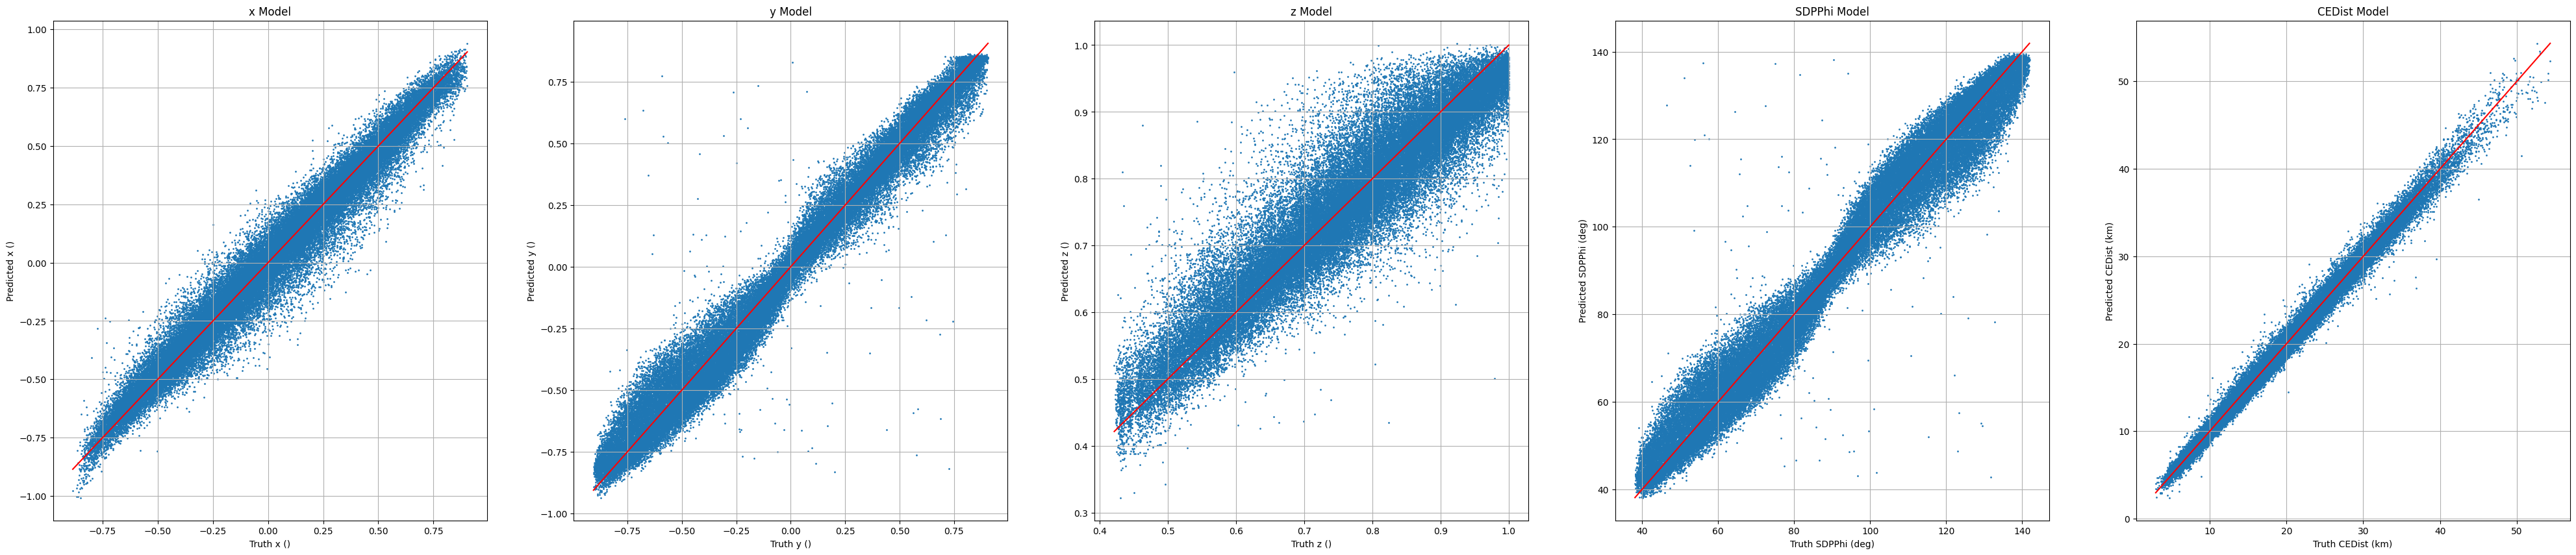

In [16]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()

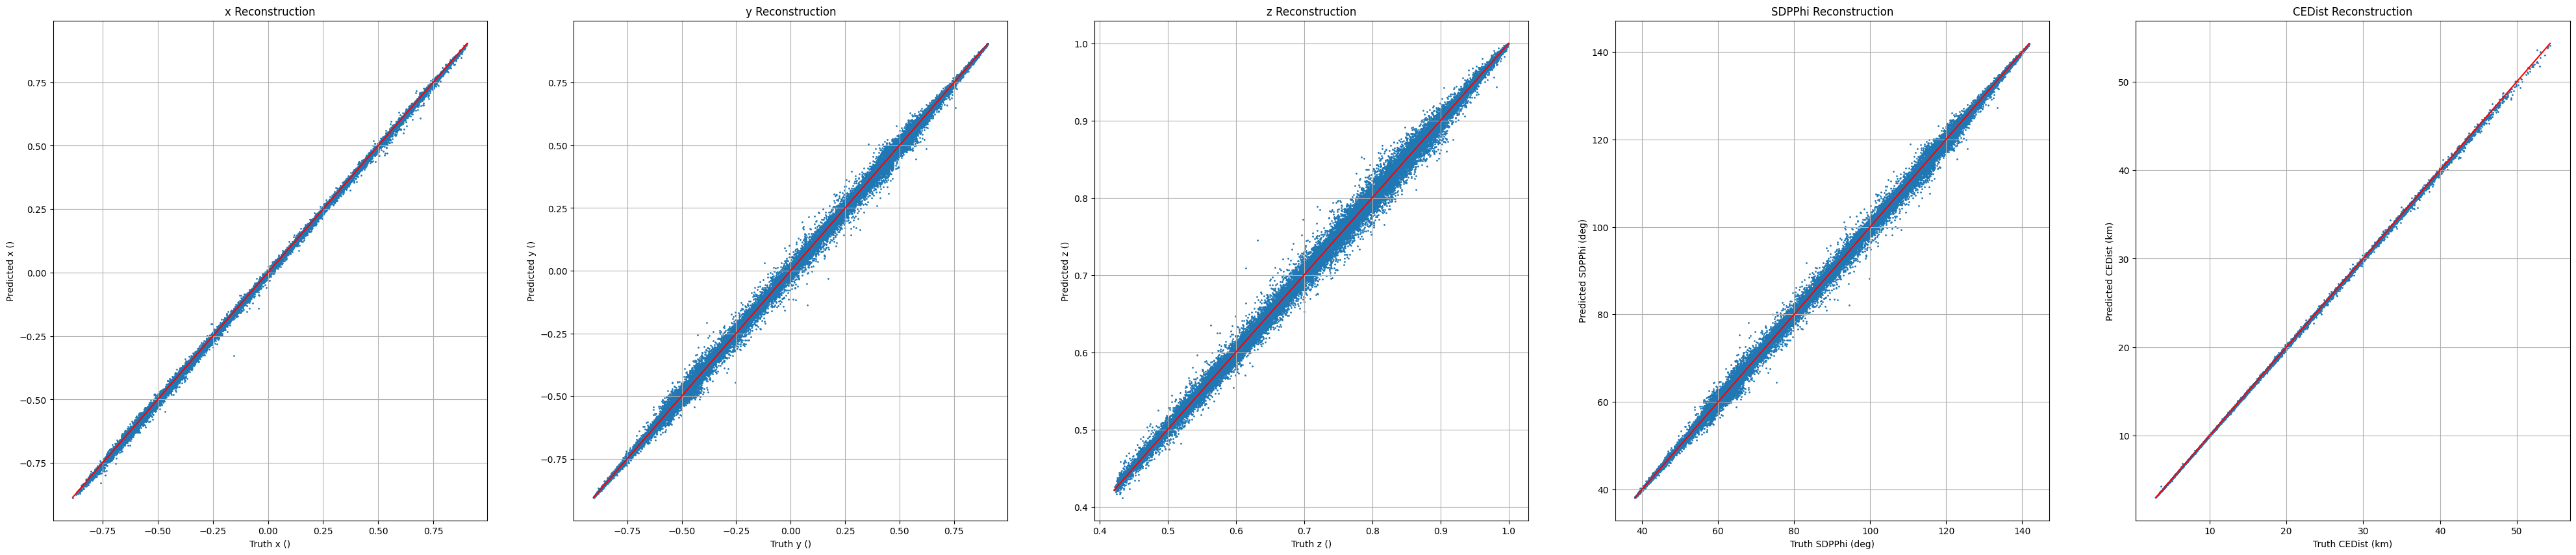

In [17]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()


### Make plots based on the Axis Geometry

In [18]:
# Colormap Truncation
from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the inferno colormap (first 90%)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated_{cmap.name}', 
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Original inferno colormap
inferno = plt.get_cmap('inferno_r')

# Truncated colormap: first 90%
truncated_inferno = truncate_colormap(inferno, 0.05, 1)


Total Points before cuts 61620
x Total Points after cuts 61465
y Total Points after cuts 61537
z Total Points after cuts 61496
SDPPhi Total Points after cuts 27092
CEDist Total Points after cuts 61502


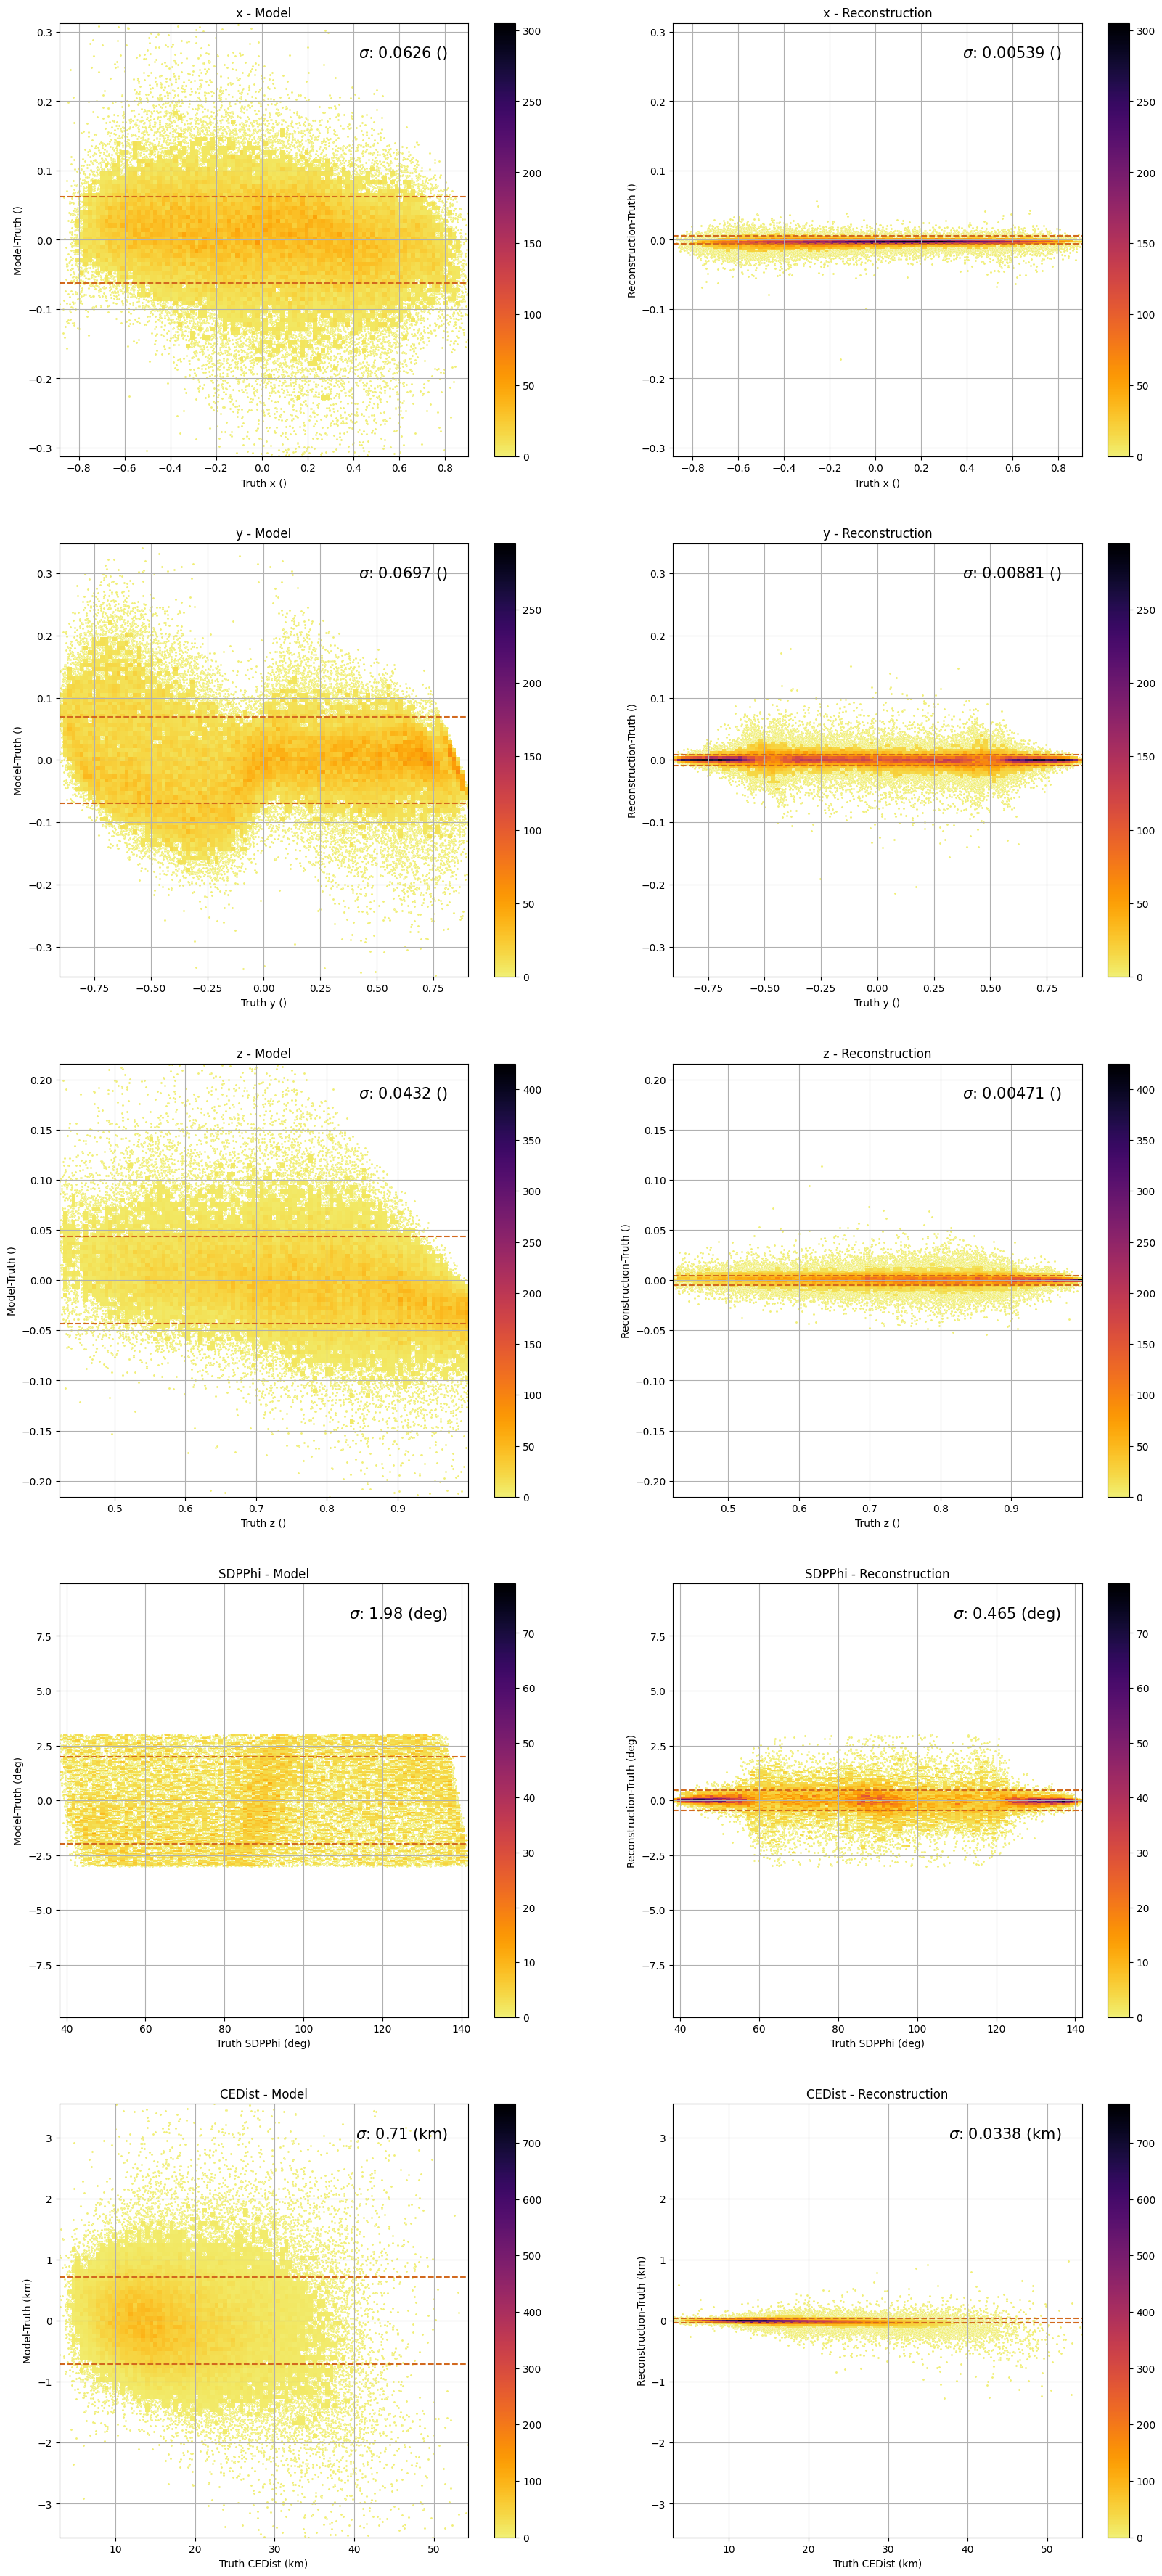

In [19]:
def CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec):
    fig, ax = plt.subplots(len(TruthKeys),2, figsize=(20,9*len(TruthKeys)))
    print(f'Total Points before cuts {len(Truth)}')
    for i in range(len(TruthKeys)):
        X  = Truth[:, i] if TruthUnits[i] != 'rad' else Truth[:, i]/np.pi*180
        Yp = Pred[:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Pred[:, i] - Truth[:, i])/np.pi*180
        Yr = Rec [:, i] - Truth[:, i] if TruthUnits[i] != 'rad' else (Rec [:, i] - Truth[:, i])/np.pi*180
        
        # Scaling Cuts
        if   TruthKeys[i] == 'SDPTheta': cut = (X > 0.1)          & (np.abs(Yp)<6)    & (np.abs(Yr)<6)
        elif TruthKeys[i] == 'SDPPhi'  : cut = (np.abs(Yp)<3)     & (np.abs(Yr)<3) #   & (np.abs(X)<50)
        elif TruthKeys[i] == 'Chi0'    : cut = (np.abs(Yp)<20)    & (np.abs(Yr)<20)
        elif TruthKeys[i] == 'Rp'      : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'CEDist'  : cut = (np.abs(Yp)<5000)  & (np.abs(Yr)<5000)
        elif TruthKeys[i] == 'T0'      : cut = (np.abs(Yp)<10000) & (np.abs(Yr)<10000)
        elif TruthKeys[i] == 'Xmax'    : cut = (np.abs(Yp)<200)   & (np.abs(Yr)<200)  & (X>100)
        elif TruthKeys[i] == 'LogE'    : cut = (X>0)              & (np.abs(Yp)<3)    & (np.abs(Yr)<3)
        elif TruthKeys[i] == 'z'       : cut = (X>0.4) 
        else: cut = (np.abs(Yp)>0)

        
        X = X[cut]
        Yp = Yp[cut]
        Yr = Yr[cut]

        # Secondary Y_lim cuts for scaling
        Yp_STD = np.percentile(np.abs(Yp),68)
        cut = (np.abs(Yp)<5*Yp_STD) & (np.abs(Yr)<5*Yp_STD)
        X  = X [cut]
        Yp = Yp[cut]
        Yr = Yr[cut]
        print(f'{TruthKeys[i]} Total Points after cuts {len(X)}')
        # sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color='orange')
        # sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color='orange')

        sns.scatterplot(x=X, y=Yp, ax=ax[i,0], s=5,color=truncated_inferno(0))
        sns.scatterplot(x=X, y=Yr, ax=ax[i,1], s=5,color=truncated_inferno(0))

        # Precompute the colorbar limits here
        hist_Yp, xedges, yedges = np.histogram2d(X,Yp,bins=100)
        hist_Yr, xedges, yedges = np.histogram2d(X,Yr,bins=100)

        vmin = min(np.min(hist_Yp),np.min(hist_Yr))
        vmax = max(np.max(hist_Yp),np.max(hist_Yr))

        sns.histplot(x=X, y=Yp, ax=ax[i,0], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True, vmin=vmin, vmax=vmax)
        sns.histplot(x=X, y=Yr, ax=ax[i,1], bins=100, pthresh=0.1,cmap = truncated_inferno,cbar = True, vmin=vmin, vmax=vmax)

        if TruthUnits[i] != 'rad': 
            ax[i,0].set_ylabel(f'Model-Truth ({TruthUnits[i]})')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            ax[i,1].set_ylabel(f'Reconstruction-Truth ({TruthUnits[i]})')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')

            
        else:                      
            ax[i,0].set_ylabel(f'Model-Truth (degrees)')
            ax[i,0].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')

            ax[i,1].set_ylabel(f'Reconstruction-Truth (degrees)')
            ax[i,1].set_xlabel(f'Truth {TruthKeys[i]} (degrees)')
        
        ax[i,0].set_title(f'{TruthKeys[i]} - Model')
        ax[i,1].set_title(f'{TruthKeys[i]} - Reconstruction')

        ax[i,0].set_xlim(min(X),max(X))
        ax[i,1].set_xlim(min(X),max(X))

        ax[i,0].grid()
        ax[i,1].grid()

        # ax[0,1].set_facecolor('lightgrey')
        # ax[1,1].set_facecolor('lightgrey')


        # 68th Percentile
        Percentile68_p = np.percentile(np.abs(Yp),68)
        Percentile68_r = np.percentile(np.abs(Yr),68)

        ax[i,0].set_ylim(-Percentile68_p*5,Percentile68_p*5)
        ax[i,1].set_ylim(-Percentile68_p*5,Percentile68_p*5)



        # Add as a texbox to top right of plot
        if TruthUnits[i]!= 'rad':
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} ({TruthUnits[i]})', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)

        else:
            ax[i,0].text(0.95, 0.95, f'$\\sigma$: {Percentile68_p:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,0].transAxes, fontsize=15)
            ax[i,1].text(0.95, 0.95, f'$\\sigma$: {Percentile68_r:.3} (deg)', verticalalignment='top', horizontalalignment='right', transform=ax[i,1].transAxes, fontsize=15)


        axhline_color = 'chocolate'
        ax[i,0].axhline(Percentile68_p, color=axhline_color, linestyle='--')
        ax[i,0].axhline(-Percentile68_p, color=axhline_color, linestyle='--')

        ax[i,1].axhline(Percentile68_r, color=axhline_color, linestyle='--')
        ax[i,1].axhline(-Percentile68_r, color=axhline_color, linestyle='--')
        
    return fig
    
figure = CombinedDeviationPlots(TruthKeys,TruthUnits,Truth,Pred,Rec)
# figure.savefig(f'../Results/{Model_Name}_Combined_Deviation.png')

### Histograms of Error Plots


Model Values
Counts [690, 695, 712, 728, 736, 689, 715, 711, 681, 752, 695, 716, 744, 728, 705, 666, 722, 662, 654, 732, 691, 664, 706, 675, 677, 690, 643, 654, 663, 624, 651, 669, 620, 619, 649, 621, 602, 658, 584, 634, 588, 612, 624, 585, 597, 531, 545, 570, 509, 536, 505, 507, 486, 526, 494, 512, 493, 480, 478, 426, 474, 443, 435, 439, 423, 391, 441, 406, 399, 397, 391, 365, 360, 407, 376, 355, 368, 347, 339, 334, 334, 353, 336, 323, 297, 295, 307, 269, 273, 263, 268, 270, 273, 266, 241, 237, 240, 248, 10289]
Bin Edges [0.0, 10.204081632653061, 20.408163265306122, 30.612244897959183, 40.816326530612244, 51.0204081632653, 61.224489795918366, 71.42857142857143, 81.63265306122449, 91.83673469387755, 102.0408163265306, 112.24489795918367, 122.44897959183673, 132.6530612244898, 142.85714285714286, 153.0612244897959, 163.26530612244898, 173.46938775510205, 183.6734693877551, 193.87755102040816, 204.0816326530612, 214.28571428571428, 224.48979591836735, 234.6938775510204, 244.8979591836734

<Figure size 1500x1500 with 0 Axes>

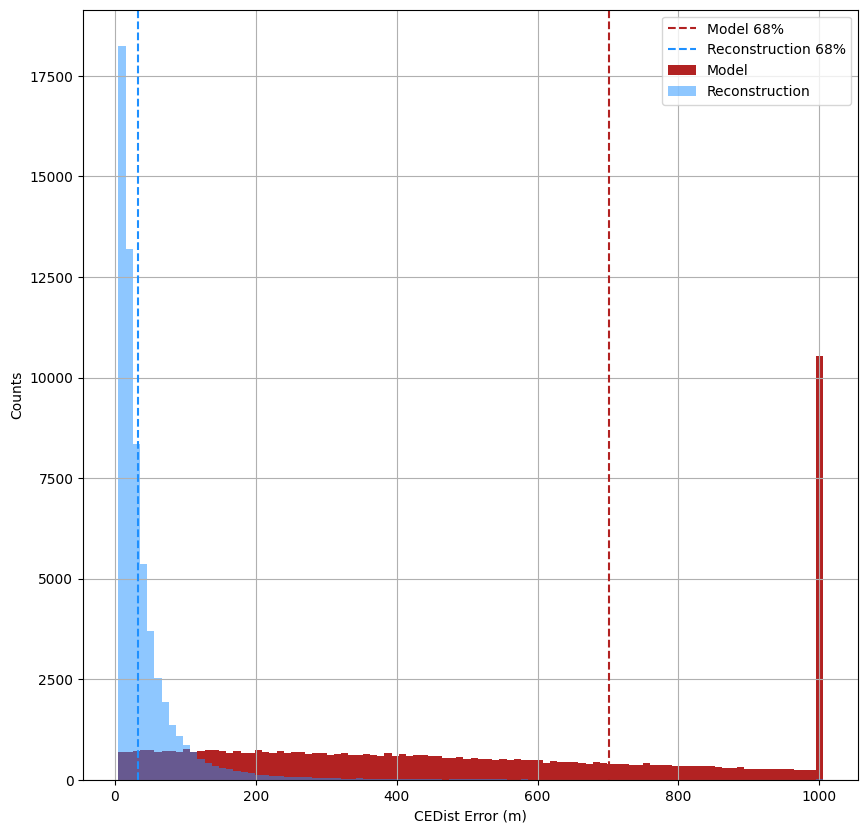

In [20]:
# Easy Stuff First - CEDist

if 'CEDist'in TruthKeys:
 
    plt.figure(figsize=(15,15))
    X  = Truth[:, TruthKeys.index('CEDist')]
    Yp = Pred [:, TruthKeys.index('CEDist')]
    Yr = Rec  [:, TruthKeys.index('CEDist')]

    E_p = np.abs(Yp-X)
    E_r = np.abs(Yr-X)

    # Make cut on 99% of the Pred Data (assuming its larger than the Rec Data)
    cut = np.percentile(E_p,99)
    cut = E_p<cut

    E_p = E_p[cut]
    E_r = E_r[cut]
    if TruthUnits[TruthKeys.index('CEDist')] == 'km':
        E_p = E_p*1000
        E_r = E_r*1000

    nbins = 100
    Range = (0,1000) 
    bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])
    
    plt.figure(figsize = (10,10))
    counts,bin_edges = np.histogram(E_p,bins=bins)
    print('Model Values')
    print('Counts',counts.tolist())
    print('Bin Edges',bin_edges.tolist())
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model',color = 'firebrick')
    
    counts,bin_edges = np.histogram(E_r,bins=bins)
    print('Reconstruction Values')
    print('Counts',counts.tolist())
    print('Bin Edges',bin_edges.tolist())
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction',color = 'dodgerblue',alpha = 0.5)
    
    plt.axvline(np.percentile(E_p,68), color='firebrick' , linestyle='--',label = 'Model 68%')
    plt.axvline(np.percentile(E_r,68), color='dodgerblue', linestyle='--',label = 'Reconstruction 68%')
    # Print the 68% vlines
    print('Sigma Pred:',np.percentile(E_p,68))
    print('Sigma Rec:',np.percentile(E_r,68))

    plt.xlabel(f'CEDist Error (m)')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

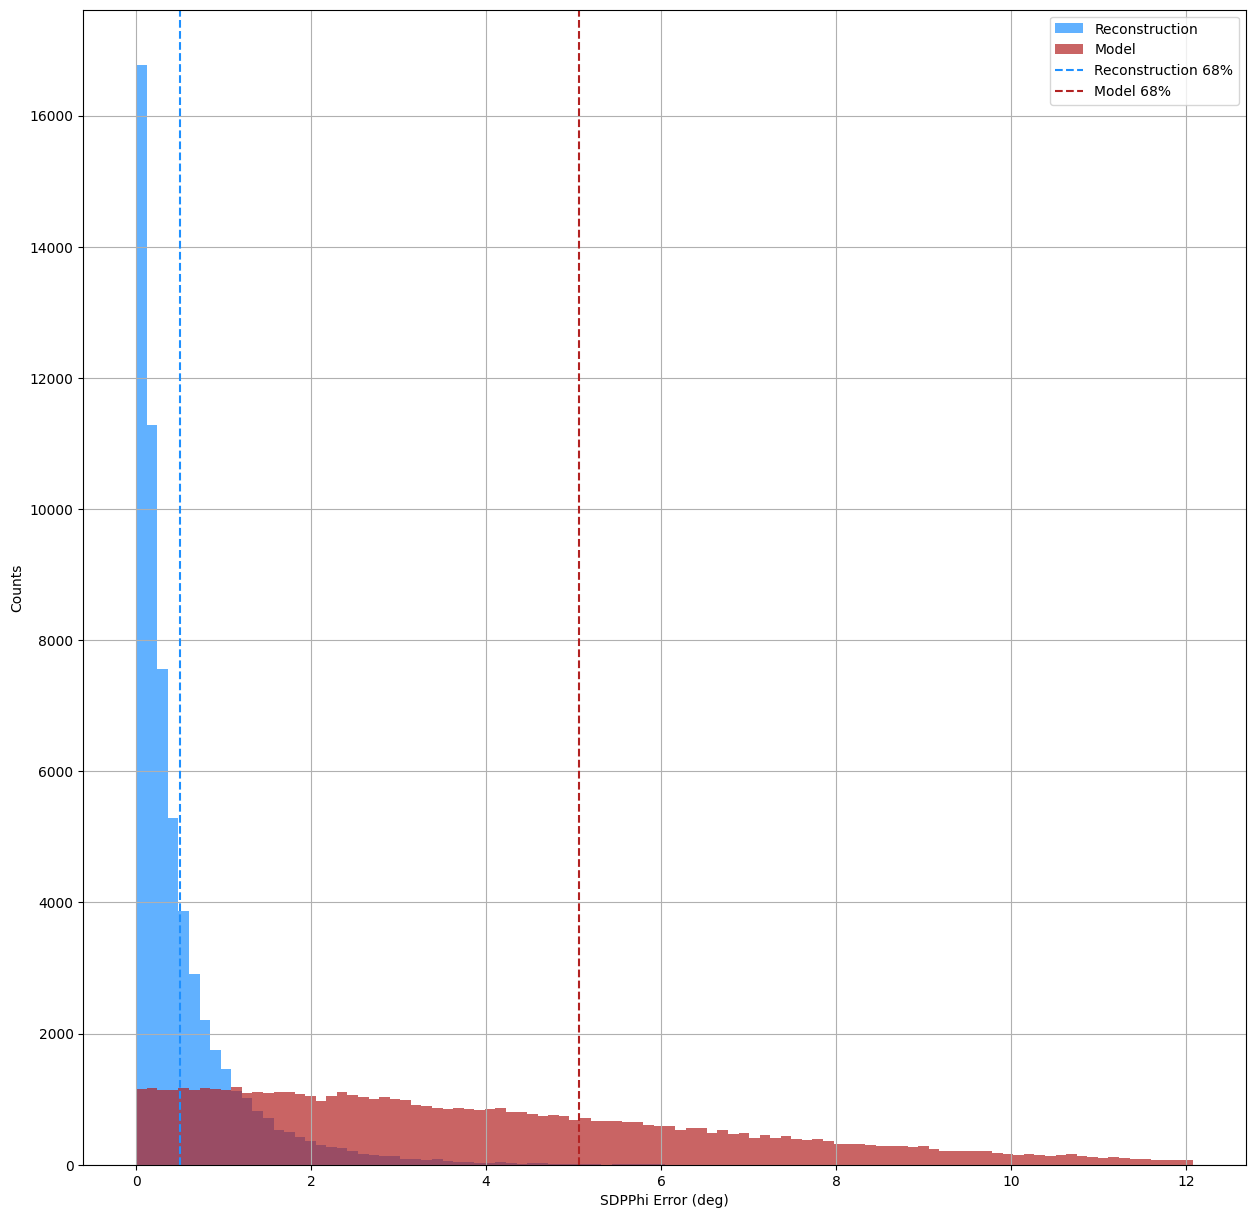

In [21]:
# Also Easy, SDPPhi

if 'SDPPhi'in TruthKeys:

    plt.figure(figsize=(15,15))
    X = Truth[:, TruthKeys.index('SDPPhi')]
    Yp = Pred [:, TruthKeys.index('SDPPhi')]
    Yr = Rec  [:, TruthKeys.index('SDPPhi')]

    E_p = np.abs(Yp-X)
    E_r = np.abs(Yr-X)

    # Make cut on 99% of the Pred Data (assuming its larger than the Rec Data)
    cut = np.percentile(E_p,99)
    cut = E_p<cut

    E_p = E_p[cut]
    E_r = E_r[cut]

    plt.hist(E_r,bins=100,range = [0,np.percentile(E_p,99)],color = 'Dodgerblue',label = 'Reconstruction',alpha = 0.7)
    plt.hist(E_p,bins=100,range = [0,np.percentile(E_p,99)],color = 'firebrick' ,label = 'Model'         ,alpha = 0.7)
    # Plot the 68% vlines
    plt.axvline(np.percentile(E_r,68), color='dodgerblue', linestyle='--',label = 'Reconstruction 68%')
    plt.axvline(np.percentile(E_p,68), color='firebrick' , linestyle='--',label = 'Model 68%')

    plt.xlabel('SDPPhi Error (deg)')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()


Model Values
Counts [8, 34, 46, 74, 99, 83, 119, 159, 175, 174, 195, 205, 208, 229, 236, 276, 275, 323, 306, 323, 348, 358, 366, 366, 380, 398, 375, 426, 437, 461, 462, 459, 441, 483, 468, 520, 488, 507, 560, 471, 524, 505, 513, 523, 520, 512, 537, 558, 545, 539, 524, 567, 537, 554, 566, 552, 546, 557, 525, 513, 551, 528, 515, 509, 556, 516, 517, 530, 510, 475, 514, 498, 499, 489, 539, 483, 517, 549, 502, 521, 494, 488, 492, 467, 449, 496, 483, 441, 467, 424, 446, 413, 353, 435, 391, 402, 394, 370, 20359]
Bin Edges [0.0, 0.061224489795918366, 0.12244897959183673, 0.18367346938775508, 0.24489795918367346, 0.30612244897959184, 0.36734693877551017, 0.42857142857142855, 0.4897959183673469, 0.5510204081632653, 0.6122448979591837, 0.673469387755102, 0.7346938775510203, 0.7959183673469388, 0.8571428571428571, 0.9183673469387755, 0.9795918367346939, 1.0408163265306123, 1.1020408163265305, 1.163265306122449, 1.2244897959183674, 1.2857142857142856, 1.346938775510204, 1.4081632653061225, 1.469387

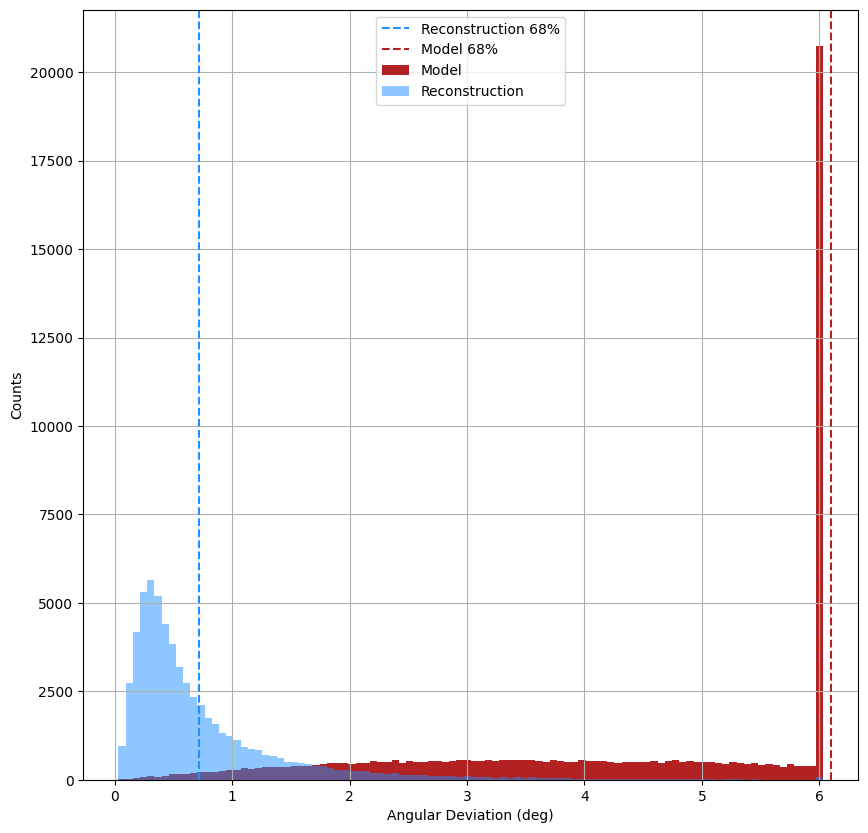

In [22]:
# Now we can combine the XYZ into a single plot to make angular deviation
if 'x' in Truth_Keys and 'y' in Truth_Keys and 'z' in Truth_Keys:
    # Normalize the vectors to unit vectors
    def normalize_vectors(vectors):
        norms = np.linalg.norm(vectors, axis=1)
        return vectors / norms[:, np.newaxis]

    # Compute the angular deviation
    def compute_angular_deviation(truth, pred, rec):
        truth = normalize_vectors(truth)
        pred = normalize_vectors(pred)
        rec = normalize_vectors(rec)
        

        pred_dot_product = np.einsum('ij,ij->i', truth, pred)
        rec_dot_product = np.einsum('ij,ij->i', truth, rec)
        
        pred_ang_div = np.arccos(np.clip(pred_dot_product, -1.0, 1.0))
        rec_ang_div = np.arccos(np.clip(rec_dot_product, -1.0, 1.0))

        return pred_ang_div, rec_ang_div
    
    AngDivPred, AngDivRec = compute_angular_deviation(Truth[:, Truth_Keys.index('x'):Truth_Keys.index('z')+1], Pred[:, Truth_Keys.index('x'):Truth_Keys.index('z')+1], Rec[:, Truth_Keys.index('x'):Truth_Keys.index('z')+1])

    AngDivPred = np.rad2deg(AngDivPred)
    AngDivRec = np.rad2deg(AngDivRec)

    nbins = 100
    Range = (0,6)
    bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

    plt.figure(figsize = (10,10))
 
    counts,bin_edges = np.histogram(AngDivPred,bins=bins)
    print('Model Values')
    print('Counts',counts.tolist())
    print('Bin Edges',bin_edges.tolist())
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model',color = 'firebrick')

    counts,bin_edges = np.histogram(AngDivRec,bins=bins)
    print('Reconstruction Values')
    print('Counts',counts.tolist())
    print('Bin Edges',bin_edges.tolist())
    counts[-2] += counts[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction',color = 'dodgerblue',alpha = 0.5)

    # Plot hlines for the 68%
    plt.axvline(np.percentile(AngDivRec  ,68), color='dodgerblue', linestyle='--',label = 'Reconstruction 68%')
    plt.axvline(np.percentile(AngDivPred ,68), color='firebrick' , linestyle='--',label = 'Model 68%')

    print('Sigma Pred:',np.percentile(AngDivPred,68))
    print('Sigma Rec:' ,np.percentile(AngDivRec ,68))
    
    plt.xlabel('Angular Deviation (deg)')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()


### Now Convert to the standard geometry

In [23]:
# Assume Axis -> Standard

if 'x' in Truth_Keys and 'y' in Truth_Keys and 'z' in Truth_Keys and 'SDPPhi' in Truth_Keys and 'CEDist' in Truth_Keys:
    print('Found All Keys')
else:
    raise ValueError('Missing Keys')


# Chi 0  should be the atan2 of x and z
Truth_Chi_0 = np.arctan2(Truth[:,Truth_Keys.index('x')],Truth[:,Truth_Keys.index('z')])
Pred_Chi_0  = np.arctan2(Pred [:,Truth_Keys.index('x')],Pred [:,Truth_Keys.index('z')])
Rec_Chi_0   = np.arctan2(Rec  [:,Truth_Keys.index('x')],Rec  [:,Truth_Keys.index('z')])

# Shift by +pi/2
Truth_Chi_0 += np.pi/2
Pred_Chi_0  += np.pi/2
Rec_Chi_0   += np.pi/2

Truth_Theta = np.arcsin(Truth[:,Truth_Keys.index('y')])
Pred_Theta  = np.arcsin(Pred [:,Truth_Keys.index('y')])
Rec_Theta   = np.arcsin(Rec  [:,Truth_Keys.index('y')])

# Shift by +pi/2
Truth_Theta += np.pi/2
Pred_Theta  += np.pi/2
Rec_Theta   += np.pi/2

# SDPPhi remains untourched

# Rp
Truth_Rp = Truth[:,Truth_Keys.index('CEDist')] * np.sin(np.pi-Truth_Chi_0)
Pred_Rp  = Pred [:,Truth_Keys.index('CEDist')] * np.sin(np.pi-Pred_Chi_0)
Rec_Rp   = Rec  [:,Truth_Keys.index('CEDist')] * np.sin(np.pi-Rec_Chi_0)


    

Found All Keys


Model Values
Counts [696, 721, 707, 690, 718, 699, 710, 721, 669, 721, 719, 704, 674, 683, 661, 673, 688, 697, 688, 708, 647, 671, 688, 649, 667, 650, 641, 605, 606, 562, 631, 655, 623, 603, 540, 584, 585, 555, 560, 593, 528, 597, 585, 595, 527, 517, 550, 524, 472, 477, 499, 450, 487, 466, 497, 463, 481, 433, 435, 425, 384, 404, 395, 376, 385, 402, 391, 387, 387, 351, 387, 332, 338, 348, 352, 318, 354, 332, 365, 322, 306, 293, 284, 272, 272, 310, 258, 287, 264, 273, 256, 239, 232, 236, 227, 222, 267, 254, 12671]
Bin Edges [0.0, 10.204081632653061, 20.408163265306122, 30.612244897959183, 40.816326530612244, 51.0204081632653, 61.224489795918366, 71.42857142857143, 81.63265306122449, 91.83673469387755, 102.0408163265306, 112.24489795918367, 122.44897959183673, 132.6530612244898, 142.85714285714286, 153.0612244897959, 163.26530612244898, 173.46938775510205, 183.6734693877551, 193.87755102040816, 204.0816326530612, 214.28571428571428, 224.48979591836735, 234.6938775510204, 244.8979591836734

<Figure size 1500x1500 with 0 Axes>

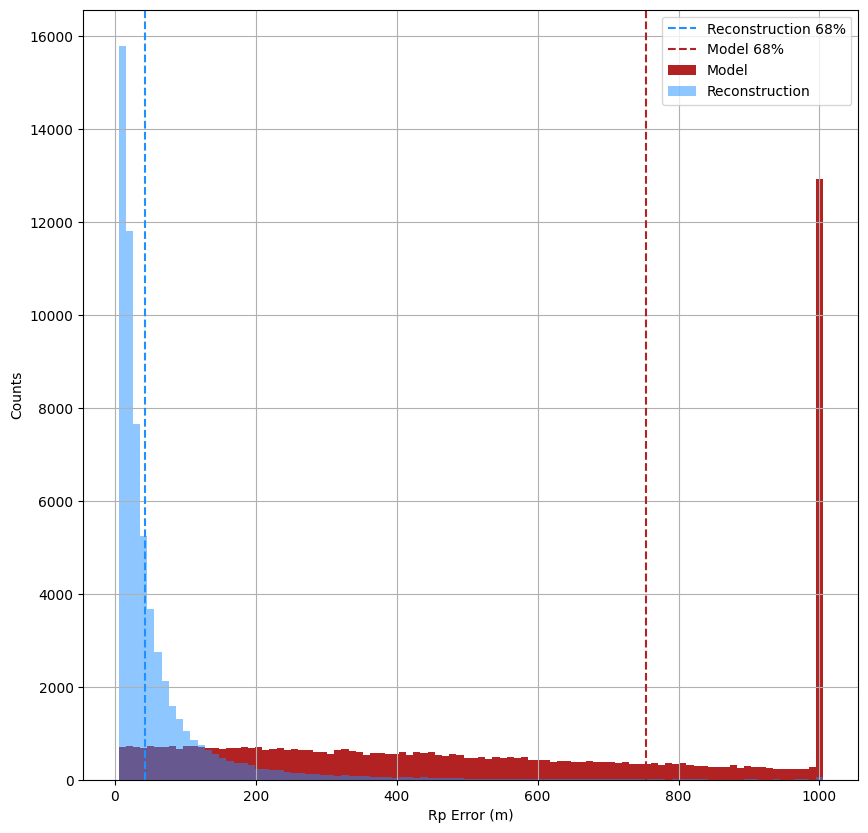

In [24]:
# R_p error histograms

plt.figure(figsize=(15,15))
X  = Truth_Rp
Yp = Pred_Rp
Yr = Rec_Rp

E_p = np.abs(Yp-X)
E_r = np.abs(Yr-X)

# Make cut on 99% of the Pred Data (assuming its larger than the Rec Data)
cut = np.percentile(E_p,99)
cut = E_p<cut

E_p = E_p[cut]
E_r = E_r[cut]

if TruthUnits[TruthKeys.index('CEDist')] == 'km':
        E_p = E_p*1000
        E_r = E_r*1000

nbins = 100
Range = (0,1000)

bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

plt.figure(figsize = (10,10))

counts,bin_edges = np.histogram(E_p,bins=bins)
print('Model Values')
print('Counts',counts.tolist())
print('Bin Edges',bin_edges.tolist())
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model',color = 'firebrick')

counts,bin_edges = np.histogram(E_r,bins=bins)
print('Reconstruction Values')
print('Counts',counts.tolist())
print('Bin Edges',bin_edges.tolist())
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction',color='dodgerblue',alpha = 0.5)

# Plot the 68% vlines
plt.axvline(np.percentile(E_r,68), color='dodgerblue', linestyle='--',label = 'Reconstruction 68%')
plt.axvline(np.percentile(E_p,68), color='firebrick' , linestyle='--',label = 'Model 68%')

print('Sigma Pred:',np.percentile(E_p,68))
print('Sigma Rec:',np.percentile(E_r,68))


plt.xlabel(f'Rp Error (m)')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()




Model Values
Counts [668, 680, 649, 654, 683, 707, 649, 674, 604, 637, 661, 704, 638, 688, 659, 624, 675, 656, 630, 621, 606, 614, 673, 661, 647, 601, 598, 634, 629, 607, 592, 615, 568, 613, 547, 585, 588, 549, 535, 534, 533, 511, 558, 509, 527, 552, 544, 538, 492, 501, 483, 520, 523, 546, 467, 449, 475, 447, 444, 416, 456, 485, 420, 457, 405, 415, 450, 401, 402, 408, 364, 402, 373, 390, 353, 356, 358, 337, 360, 347, 340, 309, 341, 344, 342, 324, 295, 273, 292, 277, 294, 254, 262, 300, 245, 281, 250, 234, 12615]
Bin Edges [0.0, 0.061224489795918366, 0.12244897959183673, 0.18367346938775508, 0.24489795918367346, 0.30612244897959184, 0.36734693877551017, 0.42857142857142855, 0.4897959183673469, 0.5510204081632653, 0.6122448979591837, 0.673469387755102, 0.7346938775510203, 0.7959183673469388, 0.8571428571428571, 0.9183673469387755, 0.9795918367346939, 1.0408163265306123, 1.1020408163265305, 1.163265306122449, 1.2244897959183674, 1.2857142857142856, 1.346938775510204, 1.4081632653061225, 1

<Figure size 1500x1500 with 0 Axes>

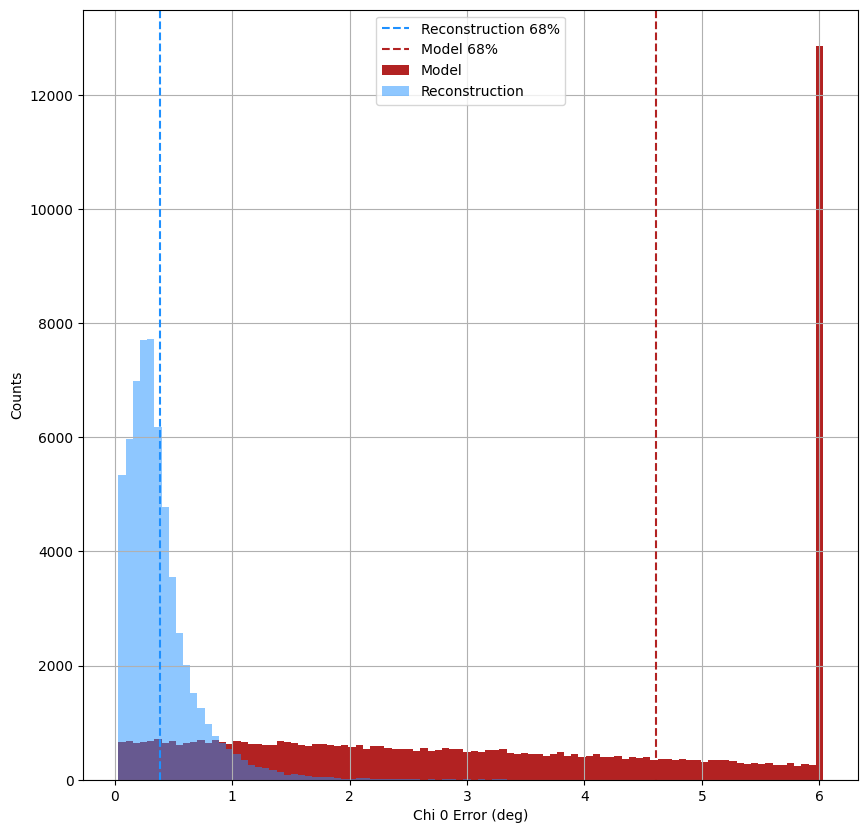

In [25]:
# Chi 0 error histograms

plt.figure(figsize=(15,15))
X  = Truth_Chi_0
Yp = Pred_Chi_0
Yr = Rec_Chi_0

E_p = np.abs(Yp-X)
E_r = np.abs(Yr-X)

# Make cut on 99% of the Pred Data (assuming its larger than the Rec Data)
cut = np.percentile(E_p,99)
cut = E_p<cut

E_p = E_p[cut]
E_r = E_r[cut]

E_p = np.rad2deg(E_p)
E_r = np.rad2deg(E_r)

nbins = 100
Range = (0,6)

bins = np.concatenate([np.linspace(Range[0], Range[1], nbins-1), [np.inf]])

plt.figure(figsize = (10,10))

counts,bin_edges = np.histogram(E_p,bins=bins)
print('Model Values')
print('Counts',counts.tolist())
print('Bin Edges',bin_edges.tolist())
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Model',color = 'firebrick')

counts,bin_edges = np.histogram(E_r,bins=bins)
print('Reconstruction Values')
print('Counts',counts.tolist())
print('Bin Edges',bin_edges.tolist())
counts[-2] += counts[-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
plt.bar(bin_centers[:-1], counts[:-1], width=np.diff(bin_edges[:-1]), align="edge", label='Reconstruction',color = 'dodgerblue',alpha = 0.5)

# Plot the 68% vlines
plt.axvline(np.percentile(E_r,68), color='dodgerblue', linestyle='--',label = 'Reconstruction 68%')
plt.axvline(np.percentile(E_p,68), color='firebrick' , linestyle='--',label = 'Model 68%')
print('Sigma Pred:',np.percentile(E_p,68))
print('Sigma Rec:',np.percentile(E_r,68))

plt.xlabel('Chi 0 Error (deg)')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()
